##AV2 NLP

Explicação do Código

-Importações: As bibliotecas necessárias são importadas, incluindo torch, pandas, transformers, e sklearn.

-Carregar Dataset: O arquivo CSV com os dados é lido e uma amostra de 20% é criada.

-Classe TweetDataset: Define um dataset personalizado para lidar com a tokenização e preparação dos dados.

-O método __getitem__ utiliza a função encode_plus do tokenizer para converter textos em IDs de entrada e máscaras de atenção.

-Carregar Tokenizer e Modelo: O tokenizer e o modelo BERT pré-treinados são carregados. O parâmetro hidden_dropout_prob é ajustado para aumentar a regularização.

-Dividir Dataset: Os dados são divididos em conjuntos de treinamento e teste, utilizando uma divisão de 80/20.

-Criar Dataloaders: Os datasets de treinamento e teste são convertidos em DataLoader, facilitando o carregamento em lotes durante o treinamento.

In [2]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Ler o arquivo CSV
df = pd.read_csv('/content/twitter-sentiment-pt-BR-md-2-l.csv')

# Reduzir o dataset para 20% dos dados
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

# Preparar dataset
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Carregar tokenizer e modelo
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = BertForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=2,
    hidden_dropout_prob=0.5  # Aumentar dropout para regularização
)

# Dividir o dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['tweet_text'].values,
    df['sentiment'].values,
    test_size=0.2,
    random_state=42
)

# Criar datasets e dataloaders
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len=128)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


-Otimizador: O AdamW é utilizado com uma taxa de aprendizado de 1e-6 e regularização L2 (weight_decay=0.01).

-Dispositivo: O modelo é movido para a GPU, se disponível, usando torch.device.

-Parâmetros de Treinamento:

EPOCHS: Total de épocas de treinamento.
best_val_loss: Inicializa a melhor perda de validação.
patience: Número de épocas sem melhoria antes do early stopping.
Loop de Treinamento: Para cada época:

O modelo é colocado em modo de treinamento (model.train()).
A perda total da época é acumulada.

Para cada batch do train_loader, os gradientes são zerados, e os IDs de entrada, máscaras de atenção e rótulos são movidos para o dispositivo.

O modelo calcula a perda, realiza a retropropagação (loss.backward()) e atualiza os parâmetros (optimizer.step()).
A perda total da época é impressa.

-Validação: O modelo é avaliado após cada época:

É colocado em modo de avaliação (model.eval()).
A perda de validação é calculada sem calcular gradientes (with torch.no_grad()).

Early Stopping: Se a perda de validação melhorar, best_val_loss é atualizado e o contador de paciência é zerado. Caso contrário, o contador aumenta e, se atingir o limite de paciência, o treinamento é interrompido.

In [3]:
# Otimizador com redução da taxa de aprendizado e regularização L2
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.01)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Early Stopping com paciência de 2 épocas
EPOCHS = 10
best_val_loss = float('inf')
patience = 2
patience_counter = 0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1} finished with loss: {total_loss:.4f}")

    # Avaliar no conjunto de validação/teste a cada época
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    print(f"Validation Loss: {val_loss:.4f}")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping")
            break


Epoch 1 finished with loss: 142.5197
Validation Loss: 34.8021
Epoch 2 finished with loss: 139.7764
Validation Loss: 34.4559
Epoch 3 finished with loss: 139.2780
Validation Loss: 34.1515
Epoch 4 finished with loss: 137.8849
Validation Loss: 33.7748
Epoch 5 finished with loss: 137.1891
Validation Loss: 33.3952
Epoch 6 finished with loss: 135.2793
Validation Loss: 32.9394
Epoch 7 finished with loss: 133.6771
Validation Loss: 32.2935
Epoch 8 finished with loss: 131.0360
Validation Loss: 31.6873
Epoch 9 finished with loss: 126.4592
Validation Loss: 30.4139
Epoch 10 finished with loss: 118.7683
Validation Loss: 28.1960


Pipeline de Inferência:

O pipeline de sentiment-analysis é criado com o modelo e tokenizer previamente definidos. O parâmetro device é ajustado para usar a GPU se disponível (device=0), caso contrário, usa a CPU (device=-1).

Inferência:

Os textos do conjunto de teste são convertidos em uma lista (test_texts.tolist()).
A inferência é realizada chamando o classifier, que retorna as previsões.
Processamento das Previsões:

As previsões retornadas contêm rótulos como 'LABEL_0' ou 'LABEL_1'. A lista predicted_labels é criada convertendo esses rótulos em 0 e 1, respectivamente.

In [4]:
# Inferência com pipeline
classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Fazer inferência no conjunto de teste
test_texts_list = test_texts.tolist()
predictions = classifier(test_texts_list)
predicted_labels = [0 if pred['label'] == 'LABEL_0' else 1 for pred in predictions]


Importação de Métricas: As funções necessárias para calcular as métricas de desempenho e plotar a matriz de confusão são importadas.

Cálculo de Métricas:

accuracy_score: Calcula a acurácia do modelo.
precision_recall_fscore_support: Calcula precisão, recall e F1-Score. O parâmetro average='macro' é usado para calcular a média desses valores considerando cada classe igualmente.
Impressão das Métricas: As métricas calculadas são impressas no console.

Relatório de Classificação: Um relatório detalhado de classificação é gerado usando classification_report, que inclui precisão, recall e F1 para cada classe.

Matriz de Confusão:

A matriz de confusão é calculada usando confusion_matrix.
A matriz é plotada usando seaborn para uma visualização mais clara, com anotações sobre o número de previsões em cada célula.

Acurácia: 0.7550
Precisão: 0.7966
Recall: 0.7555
F1-Score: 0.7463

Classification Report:
              precision    recall  f1-score   support

    Negative       0.91      0.57      0.70       401
    Positive       0.68      0.94      0.79       399

    accuracy                           0.76       800
   macro avg       0.80      0.76      0.75       800
weighted avg       0.80      0.76      0.75       800



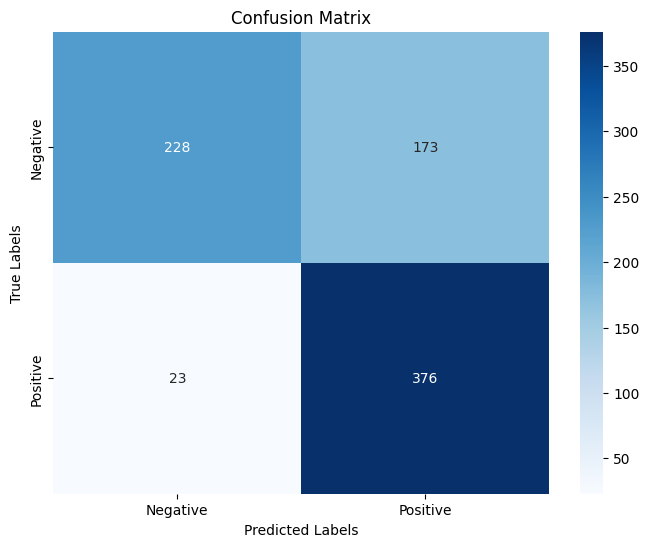

In [5]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular métricas de acurácia, precisão, recall e F1
accuracy = accuracy_score(test_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predicted_labels, average='macro')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Relatório de classificação
print("\nClassification Report:")
print(classification_report(test_labels, predicted_labels, target_names=['Negative', 'Positive']))

# Matriz de confusão
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
